In [75]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from LSTM import LSTM
import torch
import torch.nn as nn

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Preprocessing

In [2]:
# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)
    
    close_prices = data['Close'].rename(ticker + "_close")
    
    df_close = pd.concat([df_close, close_prices], axis=1)

df_close.dropna(inplace=True)

In [3]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()
  
df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)

2024-04-08 00:00:00    0.001444
2024-04-09 00:00:00   -0.009502
2024-04-10 00:00:00    0.007417
2024-04-11 00:00:00   -0.014658
2024-04-12 00:00:00         NaN
Name: ^GSPC_log_return, dtype: float64

# Model

In [20]:
df_to_model = df_log_return

In [18]:
df_to_model

,^GSPC_log_return,AAPL_log_return,MSFT_log_return,AMZN_log_return,NVDA_log_return,GOOGL_log_return,TSLA_log_return,META_log_return
2012-05-18 00:00:00,0.015909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00,0.000486,0.056626,0.016266,0.019725,0.017235,0.022578,0.042968,-0.116378
2012-05-22 00:00:00,0.001692,-0.007708,0.000336,-0.012828,-0.012280,-0.021912,0.068181,-0.093255
2012-05-23 00:00:00,0.001379,0.024107,-0.022083,0.009015,0.024411,0.014311,0.007118,0.031749
2012-05-24 00:00:00,-0.002168,-0.009226,-0.001375,-0.009433,-0.026886,-0.009562,-0.024145,0.031680
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00,0.001444,-0.006686,-0.002188,0.000648,-0.009992,0.015292,0.047837,-0.015460
2024-04-09 00:00:00,-0.009502,0.007216,0.003972,0.002589,-0.020628,0.011238,0.022296,-0.004536
2024-04-10 00:00:00,0.007417,-0.011202,-0.007110,0.001507,0.019549,-0.002942,-0.029373,0.005652
2024-04-11 00:00:00,-0.014658,0.042361,0.010973,0.016534,0.040274,0.020726,0.016400,0.006385


In [6]:
Ntest = 1000
df_train = df_to_model.iloc[1:-Ntest]
df_test = df_to_model.iloc[-Ntest:-1]

X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

## Train Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


In [12]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
lstm_model = LSTM()

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'LSTM': lstm_model
}

In [15]:
results = {}

for name, model in models.items():
    print("Training: ", name)

    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    elif name == 'LSTM':
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epochs = 30

        model.to(device)
        model.train()
        
        for i in tqdm(range(epochs)):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X[:,:,None].to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                model.reset_hidden_state()
                y_pred = model(batch_X)

                loss = loss_function(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.to(torch.device('cpu')).item()

        model.eval()

        with torch.no_grad():
            X_test_tensor = X_test_tensor[:,:,None].to(device)
            y_pred_test = model(X_test_tensor)
            y_pred_test = y_pred_test.to(torch.device('cpu')).numpy().reshape(-1)
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)
        
        y_pred_test = model.predict(X_test)
    
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )
    
    
    results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training:  NaiveForecast
Training:  LinearRegression
Training:  SVR
Training:  RFR
Training:  LSTM


100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


Model: NaiveForecast
MAE: 0.0118
MSE: 0.0003
RMSE: 0.0159
direction: 0.4825


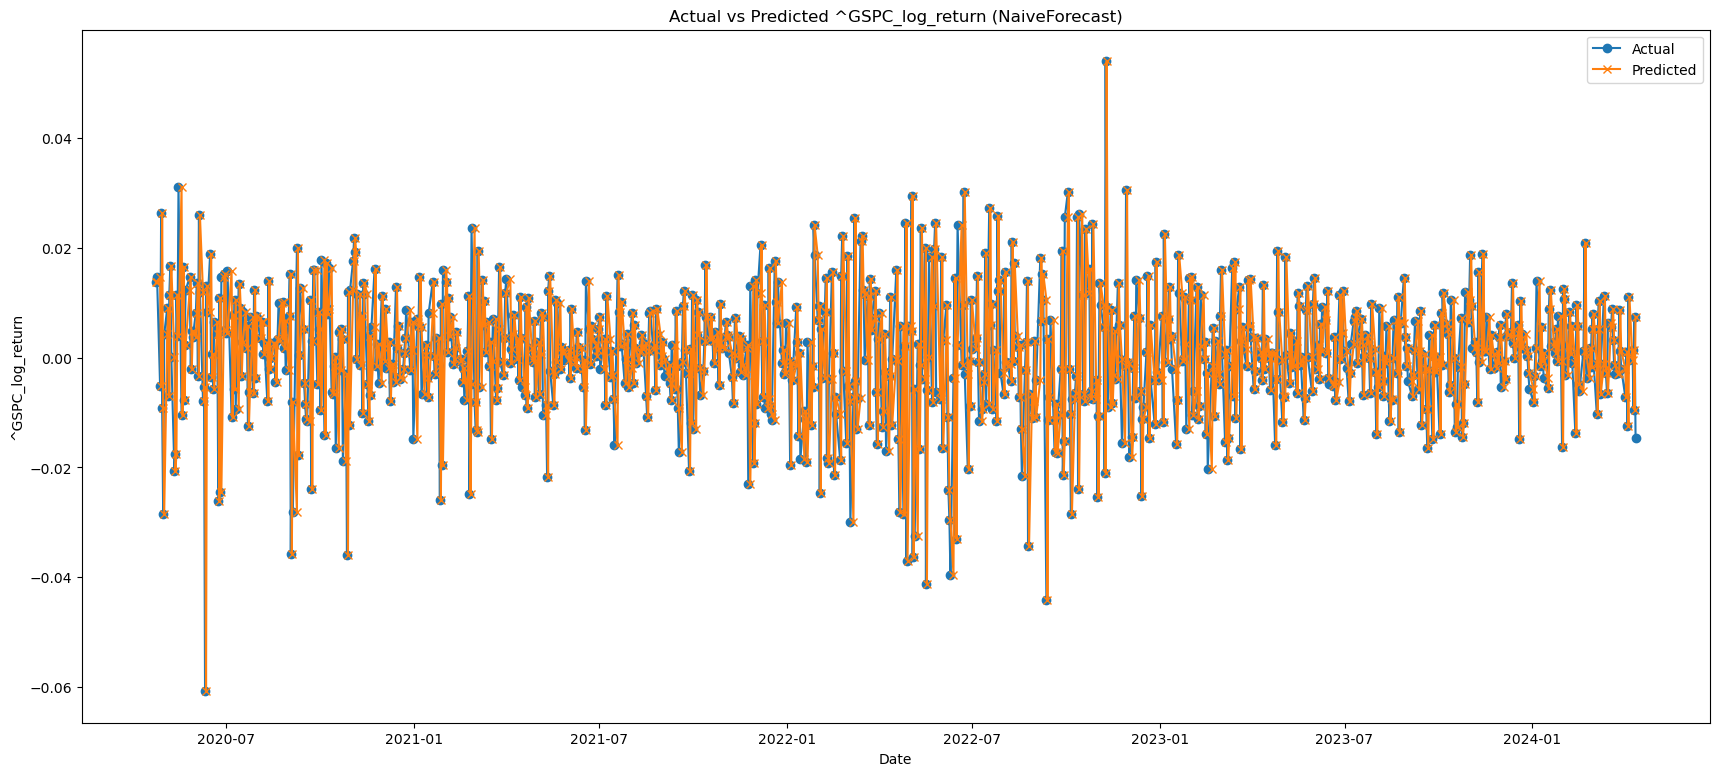

Model: LinearRegression
MAE: 0.0084
MSE: 0.0001
RMSE: 0.0112
direction: 0.5285


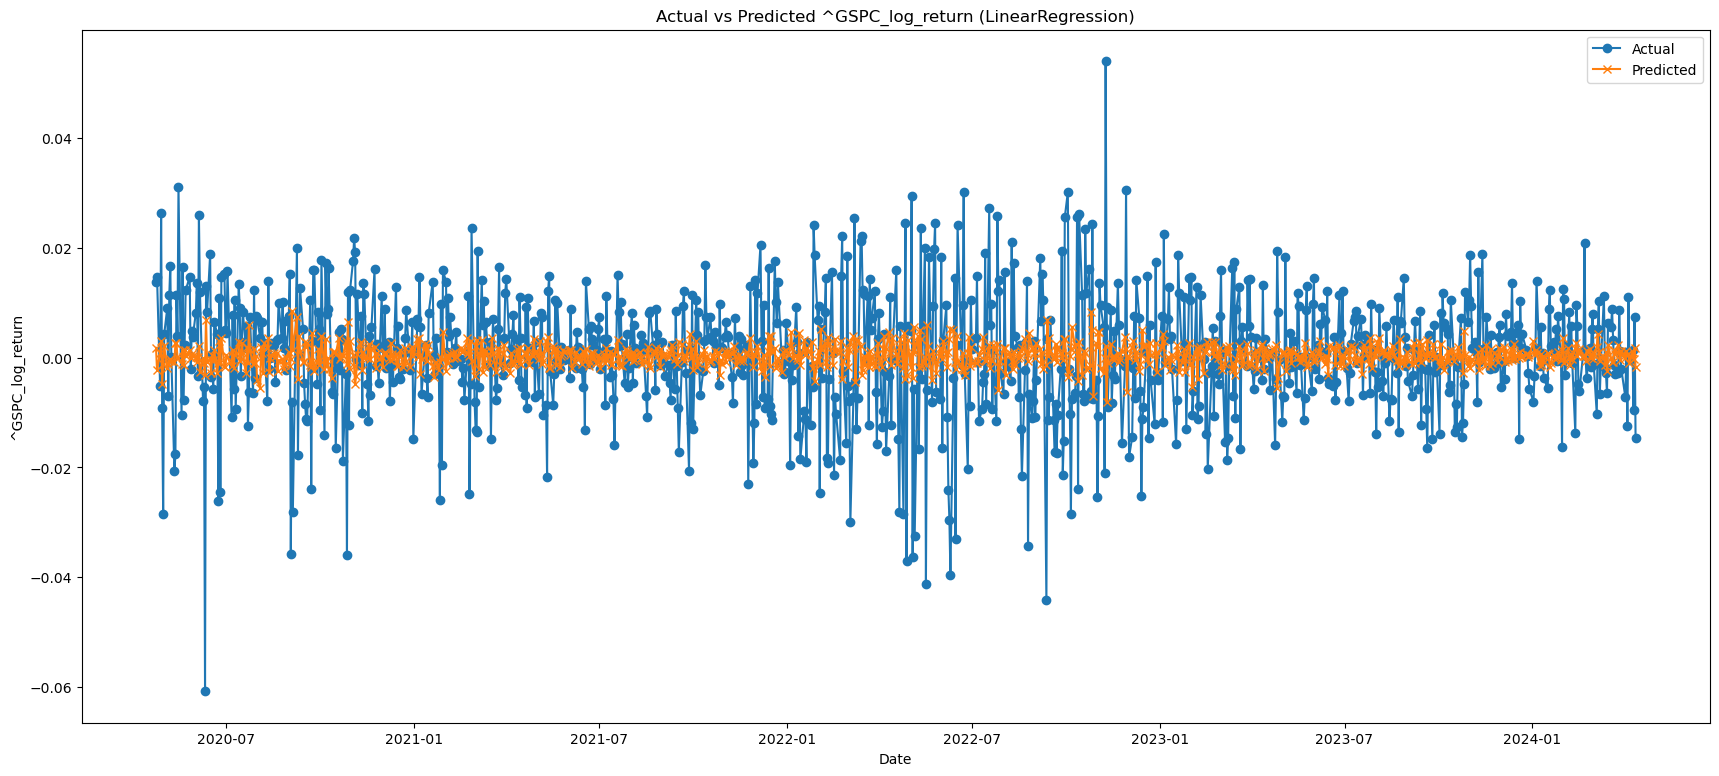

Model: SVR
MAE: 0.0169
MSE: 0.0004
RMSE: 0.0192
direction: 0.4675


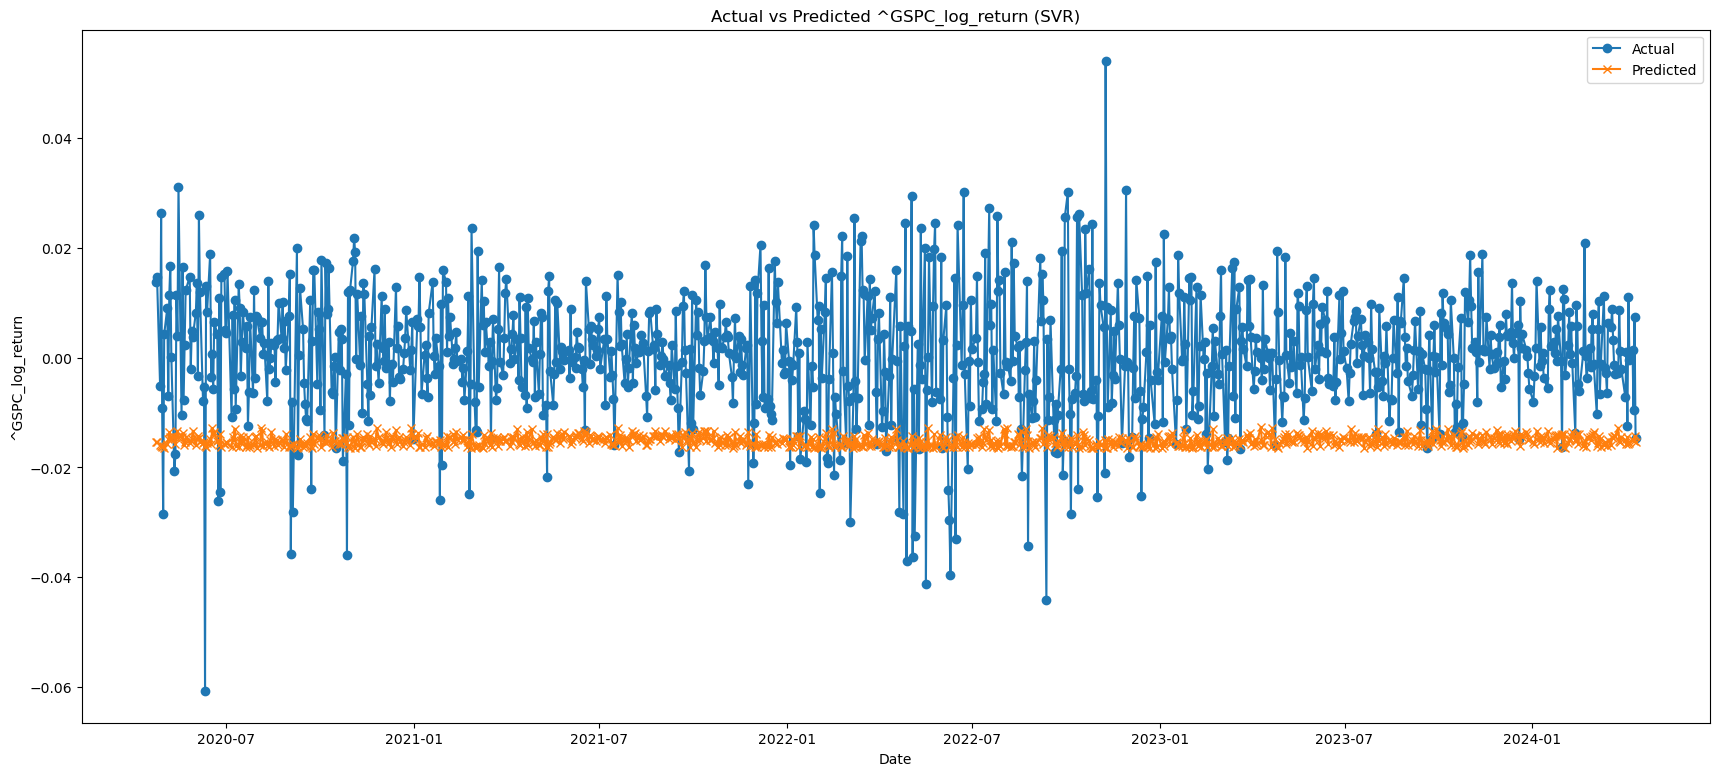

Model: RFR
MAE: 0.0087
MSE: 0.0001
RMSE: 0.0117
direction: 0.4925


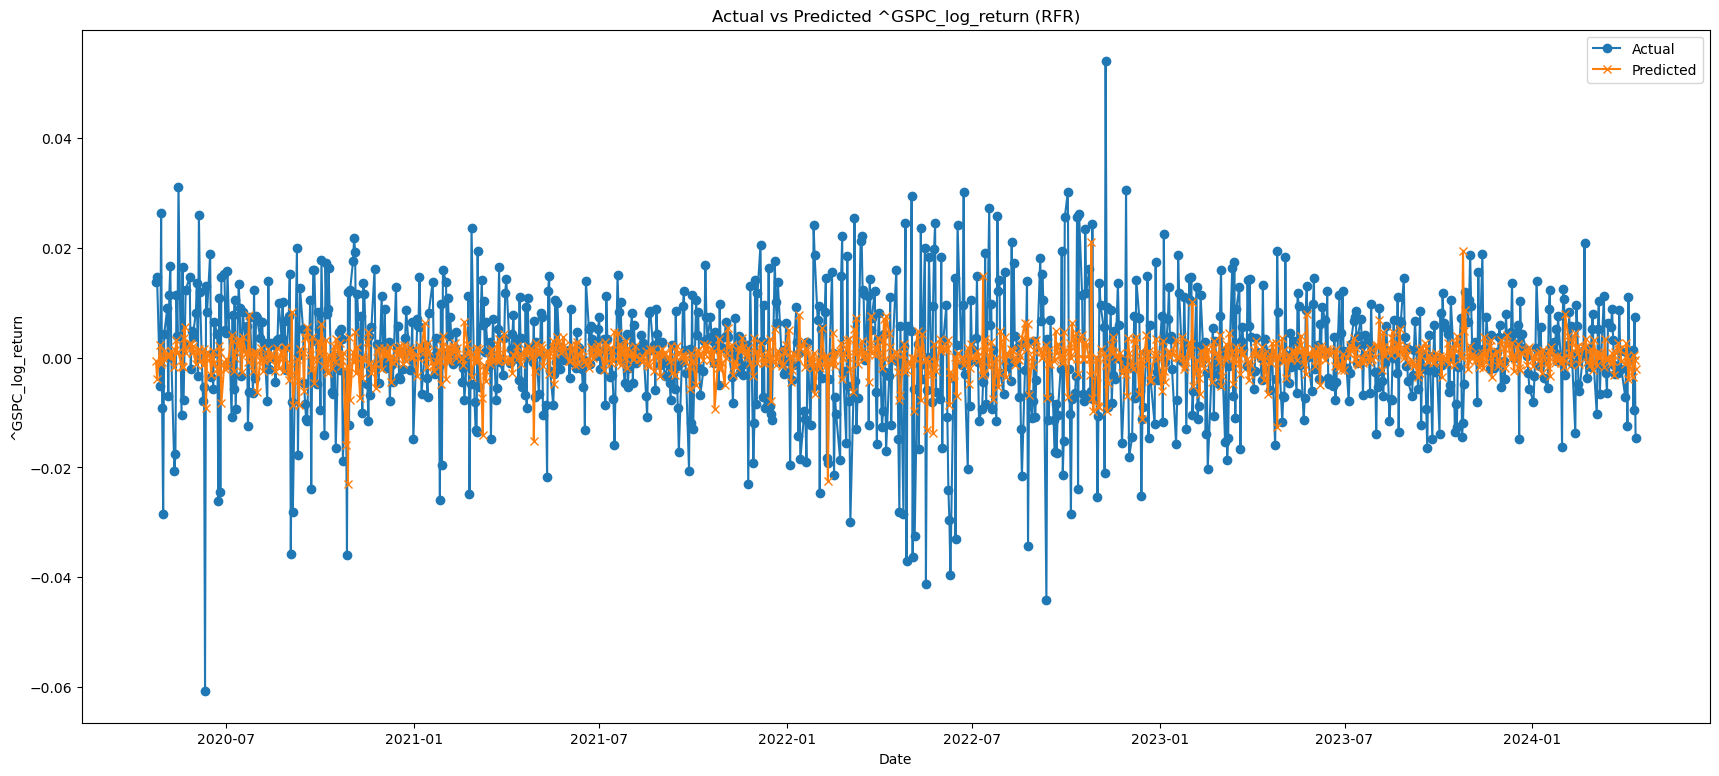

Model: LSTM
MAE: 0.0084
MSE: 0.0001
RMSE: 0.0112
direction: 0.5355


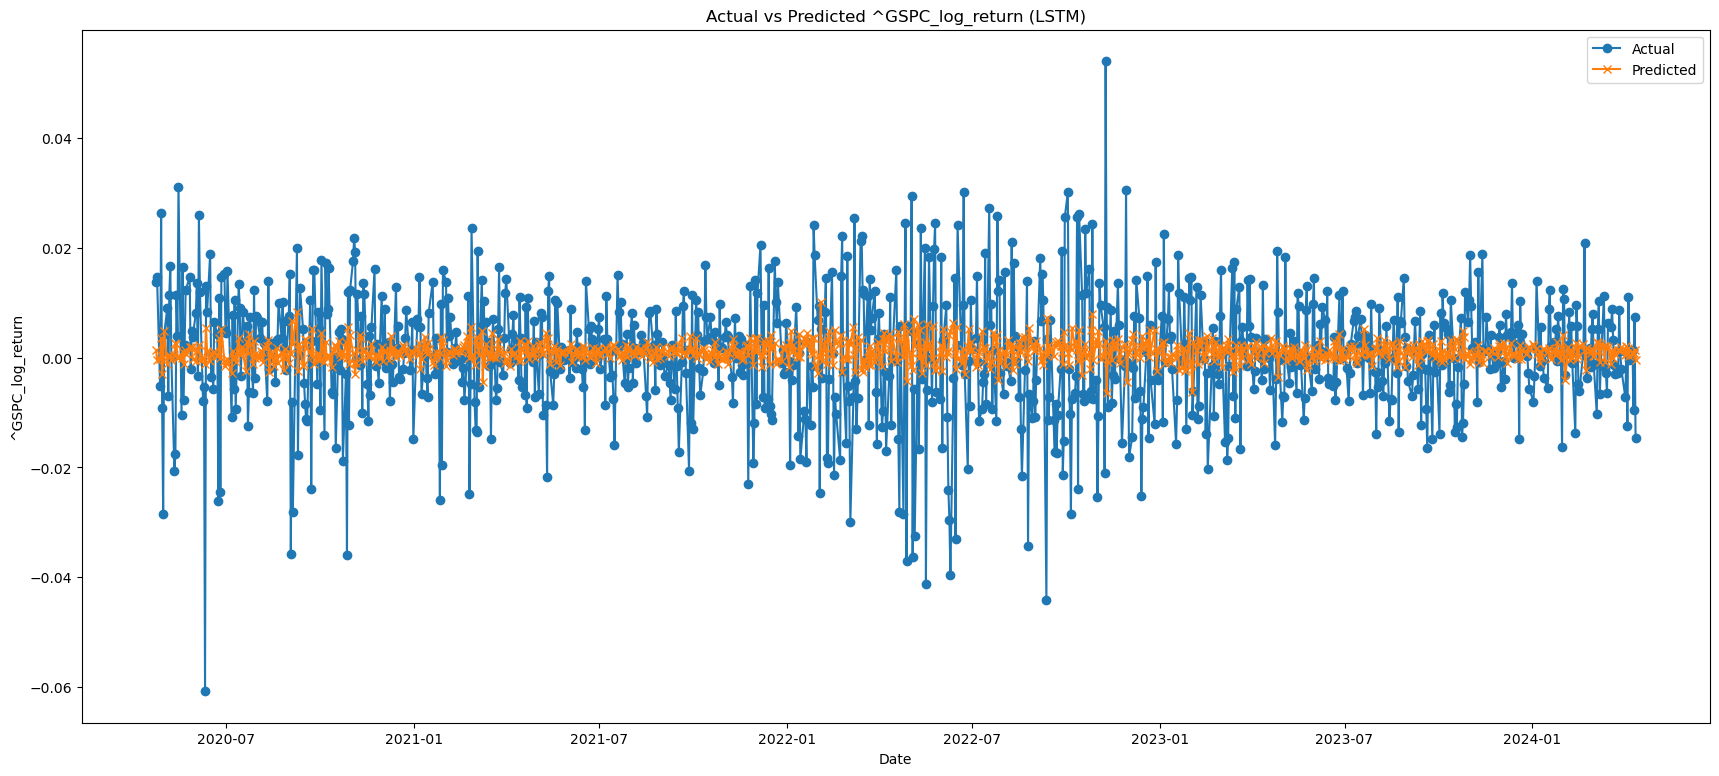

In [16]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"direction: {metrics['direction']:.4f}")
    
    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()

In [17]:
results

{'NaiveForecast': {'model': None,
  'y_pred_test': 2020-04-23    0.013822
  2020-04-24    0.013822
  2020-04-27    0.014607
  2020-04-28   -0.005256
  2020-04-29    0.026237
                  ...   
  2024-04-05    0.011038
  2024-04-08   -0.000375
  2024-04-09    0.001444
  2024-04-10   -0.009502
  2024-04-11    0.007417
  Name: ^GSPC_log_return, Length: 999, dtype: float64,
  'mae': 0.011841334065296093,
  'mse': 0.0002516576022765202,
  'rmse': 0.0158637196860169,
  'direction': 0.4824824824824825},
 'LinearRegression': {'model': LinearRegression(),
  'y_pred_test': array([ 1.77236350e-03, -2.32165320e-03,  9.14241530e-04,  3.00751268e-03,
         -4.81765368e-03, -1.25348277e-03,  2.01851019e-03, -1.91822718e-03,
         -1.13965385e-03, -5.56699302e-04, -3.04341435e-04, -6.42355800e-04,
         -8.05920809e-04,  2.55913597e-03,  2.58967015e-03,  1.75369043e-04,
         -1.65010130e-04, -1.08609167e-03,  1.44000069e-03, -1.30182630e-03,
          1.36081101e-03,  2.14857461e-04

# Trading

Strategy
- Position (Buy/Sell/do nothing) base on predicted '(log)return' of the next day
    - return > 0 : buy
    - return = 0 : do nothing
    - return < 0 : sell
- buy/sell all of portfolio in each transaction
- no short position

In [57]:
df_trading = pd.DataFrame() # on test set
df_trading['^GSPC_log_return'] = y_test

for model_name in models:
    pred_log_return = results[model_name]['y_pred_test']
    position = ( pred_log_return > 0 ) # 1: Buy, 0: Sell
    model_log_return = position * df_trading['^GSPC_log_return']
    df_trading[model_name + '_log_return'] = model_log_return

df_trading

,^GSPC_log_return,NaiveForecast_log_return,LinearRegression_log_return,SVR_log_return,RFR_log_return,LSTM_log_return
2020-04-23 00:00:00,0.013822,0.013822,0.013822,0.0,0.000000,0.013822
2020-04-24 00:00:00,0.014607,0.014607,0.000000,0.0,0.000000,0.000000
2020-04-27 00:00:00,-0.005256,-0.005256,-0.005256,-0.0,-0.005256,-0.000000
2020-04-28 00:00:00,0.026237,0.000000,0.026237,0.0,0.000000,0.026237
2020-04-29 00:00:00,-0.009255,-0.009255,-0.000000,-0.0,-0.000000,-0.000000
...,...,...,...,...,...,...
2024-04-05 00:00:00,-0.000375,-0.000375,-0.000000,-0.0,-0.000000,-0.000375
2024-04-08 00:00:00,0.001444,0.000000,0.001444,0.0,0.000000,0.001444
2024-04-09 00:00:00,-0.009502,-0.009502,-0.000000,-0.0,-0.009502,-0.009502
2024-04-10 00:00:00,0.007417,0.000000,0.007417,0.0,0.000000,0.007417


In [114]:
df_trading.index = pd.to_datetime(df_trading.index)

total_days = (df_trading.index[-1] - df_trading.index[0]).days
years = total_days // 365
months = (total_days % 365) // 30

In [136]:
buy_and_hold_total_return = np.exp(y_test.sum())

print(f'Total(Gross) Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {buy_and_hold_total_return *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {total_return *100:.2f}%')
    
print(f'\nNet Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1) *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1) *100:.2f}%')
    
print(f'\nNet Return (per year)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1)/total_days*365 *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1)/total_days*365 *100:.2f}%')

Total(Gross) Return (3 years 11 months)
----------
Buy & Hold (since 2020-04-23): 183.12%
NaiveForecast: 119.82%
LinearRegression: 183.56%
SVR: 100.00%
RFR: 128.16%
LSTM: 214.84%

Net Return (3 years 11 months)
----------
Buy & Hold (since 2020-04-23): 83.12%
NaiveForecast: 19.82%
LinearRegression: 83.56%
SVR: 0.00%
RFR: 28.16%
LSTM: 114.84%

Net Return (per year)
----------
Buy & Hold (since 2020-04-23): 20.94%
NaiveForecast: 4.99%
LinearRegression: 21.05%
SVR: 0.00%
RFR: 7.09%
LSTM: 28.93%
